In [1]:
######## MODULES ##########
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import celia_functions as cf
plt.rcParams.update({'font.size':14, "xtick.direction":"in", "ytick.direction":"in"})
#np.set_printoptions(threshold=sys.maxsize)

pyro_channels = ["Ch1","Ch2","Ch3","Ch4"] # Establishing a catagory of diagnostics will be helpful later.

C:\Users\syf83691\AppData\Local\Temp\ipykernel_14352\1139264716.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [12]:
shotsheet = cf.read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = cf.read_metadata(["Number","Wheel","Thickness (um)","Length(mm)","Material","Type"])

for key in shotsheet.keys():
    shotsheet[key] = [np.nan if re.search('[^\d.]', str(value)) else float(value) for value in shotsheet[key]] # Filter out all non numberic characters. Numeric characters being: `0123456789.`

row_has_data = ~np.all(np.isnan(cf.transform_list(shotsheet.values())), axis = 1)
shotsheet = {key: [cell for cell, cell_has_data in cf.transform_list((column, row_has_data)) if cell_has_data] for key, column in shotsheet.items()} # Filter out any rows that don't have any entries. (all nan rows)


In [13]:
for target_info in targetsheet:
    if target_info != "Number": #Don't add another target number
        shotsheet[target_info] = [targetsheet[target_info][targetsheet["Number"].index(target_number)] if target_number in targetsheet["Number"] else np.nan for target_number in shotsheet["TARGET NUMBER"]] # give each shot it's respective targetsheet information.


shotsheet["SHOT #"] = [int(shot) for shot in shotsheet["SHOT #"]] #make all shots into intergers. Will fail if there is a nan value.

In [14]:
###Initialisation
target = 0
shotsheet["relative X"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
shotsheet["relative Z"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
###Loop over all shots
for shot in shotsheet["SHOT #"]:
    s = shotsheet["SHOT #"].index(shot) #find the corrisponding index for this shot. Should be shot -1 = s.
    if shotsheet["TARGET NUMBER"][s] != target:
        delta_x = shotsheet["Target X"][s]
        delta_z = shotsheet["Target Z"][s]
        target = shotsheet["TARGET NUMBER"][s] # ASSUMES THAT WE DON'T RETURN BACK TO THE SAME TARGET.

    shotsheet["relative X"][s] = shotsheet["Target X"][s] -delta_x #make the target movement in x relitive to the first shot
    shotsheet["relative Z"][s] = shotsheet["Target Z"][s] -delta_z #make the target movement in z relitive to the first shot

shotsheet["d"] = np.linalg.norm([shotsheet["relative X"], shotsheet["relative Z"]], axis= 0) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

In [15]:
pd.DataFrame(shotsheet)

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,Thickness (um),Length(mm),Material,Type,relative X,relative Z,d
0,1,NaN,NaN,1.0,1.700,1.0,1000.0,10.0,Al,foil,NaN,NaN,NaN
1,2,NaN,NaN,1.0,NaN,1.0,1000.0,10.0,Al,foil,NaN,NaN,NaN
2,3,NaN,NaN,1.0,NaN,1.0,1000.0,10.0,Al,foil,NaN,NaN,NaN
3,4,NaN,NaN,1.0,NaN,1.0,1000.0,10.0,Al,foil,NaN,NaN,NaN
4,5,NaN,NaN,1.0,NaN,1.0,1000.0,10.0,Al,foil,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,261,3.345,5.41,125.0,0.806,7.0,50.0,8.0,Cu,asymmetric wire,1.0,0.51,1.122542
262,262,3.845,5.65,125.0,0.866,7.0,50.0,8.0,Cu,asymmetric wire,1.5,0.75,1.677051
263,263,4.445,5.97,125.0,0.859,7.0,50.0,8.0,Cu,asymmetric wire,2.1,1.07,2.356884
264,264,5.045,6.32,125.0,0.794,7.0,50.0,8.0,Cu,asymmetric wire,2.7,1.42,3.050639


### Choose which targets and channels to use here!

In [27]:
pyro_background = {"Ch1": [99,100,101,102,104,105,107,108,109,110,111,112,113,154,155,156,157,158,159,160,161,162,163,164,165,166,168,169,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,214,215,216,217,218,219,220,221,222,223,224,225,226,227,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265],
                   "Ch2": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140141,142,143,144,145,146,147,148,149,150,151,152,153],
                   "Ch3": [70,71,72,74,75,76,77,78,79,80,83,84,85,86,87,88,89,92,93,94,95,96,97,98]}

diagnostics = {"Ch1": shotsheet["SHOT #"], # TODO FILTER BY TARGET TYPE OR CREATE LIST OF COMPARABLE SHOTS
               "Ch2": shotsheet["SHOT #"],
               "Ch3": shotsheet["SHOT #"],
               "Ch4": shotsheet["SHOT #"],
               "bdot": shotsheet["SHOT #"],
               "xray": shotsheet["SHOT #"],
               "energy": shotsheet["SHOT #"]}

diagnostics_functions = {"Ch1": lambda x: x,
                         "Ch2": lambda x: x,
                         "Ch3": lambda x: x,
                         "Ch4": lambda x: x,
                         "bdot": lambda x: np.ma.masked_invalid(x).ptp(),
                         "tof": np.ptp,
                         "diode": np.ptp,
                         "xray": cf.estimate_xray_signal,
                         "energy": lambda x: x}

background_lookup = {shot: ch for ch, shots in pyro_background.items() for shot in shots} #Create a target -> channel lookup table.

background_data = cf.read_diagnostic_data(pyro_background, silent= False)
diagnostic_data = cf.read_diagnostic_data(diagnostics, functions= diagnostics_functions, silent= False)

Found 121 files:
   290124WIRESHOT100000_Ch1.csv
   290124WIRESHOT101000_Ch1.csv
   290124WIRESHOT102000_Ch1.csv
   290124WIRESHOT104_000_Ch1.csv
   290124WIRESHOT105000_Ch1.csv
   290124WIRESHOT99000_Ch1.csv
   290124WIRESHOT107000_Ch1.csv
   290124WIRESHOT108000_Ch1.csv
   290124WIRESHOT109000_Ch1.csv
   290124WIRESHOT110000_Ch1.csv
   290124WIRESHOT111000_Ch1.csv
   290124WIRESHOT112000_Ch1.csv
   290124WIRESHOT113000_Ch1.csv
   290124WIRESHOT158000_Ch1.csv
   290124WIRESHOT159000_Ch1.csv
   290124WIRESHOT160000_Ch1.csv
   290124WIRESHOT161000_Ch1.csv
   290124WIRESHOT162000_Ch1.csv
   290124WIRESHOT163000_Ch1.csv
   290124WIRESHOT164000_Ch1.csv
   290124WIRESHOT165000_Ch1.csv
   290124WIRESHOT166000_Ch1.csv
   290124WIRESHOT169000_Ch1.csv
   290124WIRESHOT168000_Ch1.csv
   290124WIRESHOT154000_Ch1.csv
   290124WIRESHOT155000_Ch1.csv
   290124WIRESHOT156000_Ch1.csv
   290124WIRESHOT157000_Ch1.csv
   290124WIRESHOT222000_Ch1.csv
   290124WIRESHOT223000_Ch1.csv
   290124WIRESHOT224000

### Background subtraction
Comment this out to remove background subtraction. Only `active_pyro_channels` will be background subtracted. 

In [28]:
active_pyro_channels = np.intersect1d(pyro_channels, list(diagnostic_data.keys()))
for ch in active_pyro_channels:
    for shot in enumerate(shotsheet["SHOT #"]):
        if shot in diagnostic_data["shot"] and shot in background_data["shot"]:
            diagnostic_data[ch][diagnostic_data["shot"].index(shot)] = np.subtract(diagnostic_data[ch][diagnostic_data["shot"].index(shot)], background_data[background_lookup[shot]][background_data["shot"].index(shot)])

### Calculate signal level for the diagnostics
The diagnostic data within `diagnostic_data` also gets merged with the metadata within `shotsheet`.

In [76]:
for key in diagnostic_data.keys():
    if key == "shot": #don't add another shot number to the shotsheet.
        continue 

    if key in pyro_channels:
        diagnostic_data[key] = [np.abs(np.nanmin(reading)) for reading in diagnostic_data[key]] #find the minima of every pyro channel

    shotsheet[key] = [diagnostic_data[key][diagnostic_data["shot"].index(shot)] if shot in diagnostic_data["shot"] else np.nan for shot in shotsheet["SHOT #"]] #add diagnostics to the shotsheet on respective shot numbers

C:\Users\syf83691\AppData\Local\Temp\ipykernel_23128\1825345040.py:6: RuntimeWarning: All-NaN axis encountered
  diagnostic_data[key] = [np.abs(np.nanmin(reading)) for reading in diagnostic_data[key]] #find the minima of every pyro channel


### Normalisation
Comment out line 3 to stop energy normalisation. Comment out line 4 to stop normalisation to the first shot on the target.

In [77]:
unique, indexes, counts = np.unique(shotsheet["TARGET NUMBER"], return_index= True, return_counts= True)
index_of_first_shot_on_this_target = np.repeat(indexes, counts)
nth_shot_on_target = np.concatenate([np.arange(1, count+1) for count in counts])

### loop over all channels
for ch in diagnostics.keys(): #loop over all diagnostic data
    shotsheet[ch] = np.divide(shotsheet[ch], shotsheet["Laser Energy (before comp) [J]"]) # Normalise for laser energy
    shotsheet[ch] = np.divide(shotsheet[ch], shotsheet[ch][index_of_first_shot_on_this_target]) # Normalise to the first shot on target. REDUNDENT FOR FOIL TARGETS.

### Setup parameters for graph

In [78]:
### best fit parameters
number_of_points = 100 #number of points for the best fit line.
#rolling_width = 0.35 #half width. only used by roll_average
confidence= 0.05 #only used by polynomial_fit

x0 = {"Ch1": [1,0],
      "Ch2": [1,0],
      "Ch3": [1,0],
      "Ch4": [1,0],
      "bdot": [1,0],
      "energy": [1,0],
      "xray": [1,0]}

constraints = {"Ch1": None, #[[lower], [upper]]
               "Ch2": None,
               "Ch3": None,
               "Ch4": None,
               "bdot": None, #scipy least_squares doesn't support equality constraints for some reason.
               "energy": None,
               "xray": None}

formatting = {"Ch1": {"colour": "aquamarine", "linestyle": "-", "marker": "^"},
              "Ch2": {"colour": "cyan", "linestyle": "-", "marker": ">"},
              "Ch3": {"colour": "dodgerblue", "linestyle": "-", "marker": "v"},
              "Ch4": {"colour": "blue", "linestyle": "-", "marker": "<"},
              "bdot": {"colour": "crimson", "linestyle": "-.", "marker": "s"},
              "energy": {"colour": "black", "linestyle": "--", "marker": "o"},
              "xray": {"colour": "darkgreen", "linestyle": ":", "marker": "x"}}

xaxis = "d"

model= cf.polynomial

### Calculate best fit

In [79]:
fit_x, fit_y, fit_delta = {}, {}, {}

for diagnostic in diagnostics:
    fit_x[diagnostic], fit_y[diagnostic], fit_delta[diagnostic] = cf.polynomial_fit(shotsheet[xaxis],
                                                                                    shotsheet[diagnostic],
                                                                                    number_of_points= number_of_points,
                                                                                    x0= x0[diagnostic],
                                                                                    constraints= constraints[diagnostic],
                                                                                    confidence= confidence,
                                                                                    model_function= model)
    

Optimal coeffients:
1.0340549458331265 -0.011454862823790591
Optimal coeffients:
0.8203632851704017 -0.05418698664403559
Optimal coeffients:
0.8176615019358939 -0.025162159873891362
Optimal coeffients:
0.9656900613447019 -0.08376290808093828
Optimal coeffients:
1.0170417778645633 -0.019347183832220206
Optimal coeffients:
0.9999996231032536 0.09406859617496129
Optimal coeffients:
0.9910489008546395 -0.06423467408600932


### Graph itslef

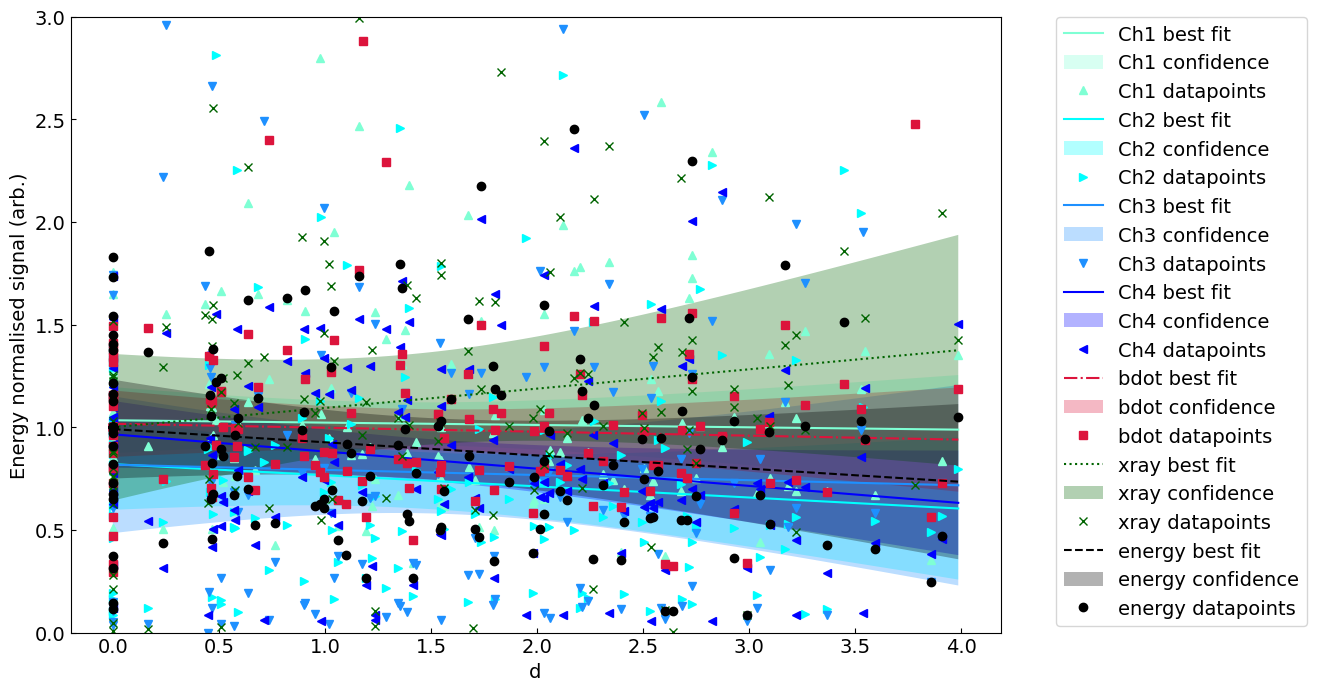

In [80]:
fig, axs = plt.subplots(1, 1, figsize= (12,8))

for diagnostic in diagnostics:

    axs.plot(fit_x[diagnostic],
             fit_y[diagnostic],
             color= formatting[diagnostic]["colour"],
             linestyle= formatting[diagnostic]["linestyle"],
             label= "{0:} best fit".format(diagnostic))
    
    axs.fill_between(fit_x[diagnostic],
                     fit_delta[diagnostic]['lwr_conf'],
                     fit_delta[diagnostic]['upr_conf'],
                     color= formatting[diagnostic]["colour"],
                     edgecolor= "None",
                     alpha= 0.3,
                     label= "{0:} confidence".format(diagnostic))
    
    axs.plot(shotsheet[xaxis],
             shotsheet[diagnostic],
             color= formatting[diagnostic]["colour"],
             linestyle= "None",
             marker= formatting[diagnostic]["marker"],
             label= "{0:} datapoints".format(diagnostic))
    
targets = np.unique(cf.flatten_list(diagnostics.values()))
axs.set(xlabel= xaxis,
        ylabel= "Energy normalised signal (arb.)",
        ylim= (0, 3))

axs.legend(loc= "upper right", bbox_to_anchor= (1.34, 1.015)) # loc fixes the location of the legend. 

plt.show()